In [ ]:
!apt-get update -qq
!apt-get install -y -qq chromium-chromedriver
!pip install -q selenium pandas openpyxl tqdm

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Preconfiguring packages ...
Selecting previously unselected package apparmor.
(Reading database ... 126455 files and directories currently installed.)
Preparing to unpack .../apparmor_3.0.4-2ubuntu2.4_amd64.deb ...
Unpacking apparmor (3.0.4-2ubuntu2.4) ...
Selecting previously unselected package squashfs-tools.
Preparing to unpack .../squashfs-tools_1%3a4.5-3build1_amd64.deb ...
Unpacking squashfs-tools (1:4.5-3build1) ...
Preparing to unpack .../libudev1_249.11-0ubuntu3.17_amd64.deb ...
Unpacking libudev1:amd64 (249.11-0ubuntu3.17) over (249.11-0ubuntu3.12) ...
Setting up libudev1:amd64 (249.11-0ubuntu3.17) ...
Selecting previously unselected package udev.
(Reading database ... 126655 files and directories currently installed.)
Preparing to unpack .../udev_249.11-0ubuntu3.17_amd64.deb ...
Unpacking 

In [ ]:
import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import time

In [ ]:
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--window-size=1920,1080')


driver = webdriver.Chrome(options=chrome_options)

In [ ]:
from tqdm import tqdm


def scroll_to_load_comments(driver, timeout=60, scroll_pause=2, max_scrolls=60):
    """Scrolls the page to force YouTube to load comments.
    Returns when no new comments appear or max_scrolls reached."""
    # Scroll down to the #comments section first
    try:
        comments_section = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, '#comments'))
        )
    except TimeoutException:
        print('Bagian komentar tidak ditemukan — mungkin komentar dinonaktifkan atau struktur halaman berubah.')
        return


    last_height = driver.execute_script('return document.documentElement.scrollHeight')
    scrolls = 0
    prev_count = 0
    pbar = tqdm(total=max_scrolls, desc='Scrolling')
    while scrolls < max_scrolls:
        # Scroll down
        driver.execute_script('window.scrollTo(0, document.documentElement.scrollHeight);')
        time.sleep(scroll_pause)
        # try to click "Show more" buttons if present (for long comments)
        try:
            more_buttons = driver.find_elements(By.CSS_SELECTOR, 'yt-formatted-string#more')
            for b in more_buttons:
                try:
                    driver.execute_script('arguments[0].click();', b)
                except Exception:
                    pass
        except Exception:
            pass


        # count loaded comment items
        items = driver.find_elements(By.CSS_SELECTOR, 'ytd-comment-thread-renderer')
        count = len(items)
        pbar.update(1)
        if count == prev_count:
            # small heuristic: if count hasn't increased after a few scrolls, break
            scrolls += 1
        else:
            prev_count = count
            scrolls = 0
        # safety stop if page height not increasing
        new_height = driver.execute_script('return document.documentElement.scrollHeight')
        if new_height == last_height:
            # maybe all loaded
            break
        last_height = new_height
    pbar.close()

In [ ]:
import pandas as pd


def extract_comments(driver, max_comments=None):
    """Extract comments, author, published time, like count, and comment id.
    max_comments: optional limit to number of comments to extract."""
    comments = []
    comment_renderers = driver.find_elements(By.CSS_SELECTOR, 'ytd-comment-thread-renderer')
    for idx, el in enumerate(comment_renderers):
        if max_comments and idx >= max_comments:
            break
        try:
            author_el = el.find_element(By.CSS_SELECTOR, '#author-text')
            author = author_el.text.strip()
        except NoSuchElementException:
            author = ''
        try:
            content_el = el.find_element(By.CSS_SELECTOR, '#content-text')
            content = content_el.text.strip()
        except NoSuchElementException:
            content = ''
        try:
            time_el = el.find_element(By.CSS_SELECTOR, 'a.yt-simple-endpoint.style-scope.yt-formatted-string')
            published = time_el.text.strip()
        except Exception:
            # fallback: find relative time
            try:
                published = el.find_element(By.CSS_SELECTOR, 'a.published-time-text').text.strip()
            except Exception:
                published = ''
        try:
            like_el = el.find_element(By.CSS_SELECTOR, '#vote-count-middle')
            likes = like_el.text.strip()
        except Exception:
            likes = ''
        # comment id from attribute
        try:
            cid = el.get_attribute('id')
        except Exception:
            cid = ''


        comments.append({
            'pengguna': author,
            'komentar': content,
            'like': likes,
        })
    df = pd.DataFrame(comments)
    return df

In [ ]:
VIDEO_URL = 'https://youtu.be/lFR4utbwliw?si=dpBjdT4GSyvW1wrZ'
print('Membuka video:', VIDEO_URL)
driver.get(VIDEO_URL)
# tunggu halaman utama termuat
try:
    WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'h1.title')))
except Exception:
    pass


# scroll untuk load komentar — tingkatkan timeout/scroll jika video banyak komentar
scroll_to_load_comments(driver, timeout=60, scroll_pause=2, max_scrolls=60)


df_comments = extract_comments(driver, max_comments=None)
print(f'Jumlah komentar ter-scrape: {len(df_comments)}')


# simpan ke Excel
output_path = 'youtube_comments.xlsx'
df_comments.to_excel(output_path, index=False)
print('Tersimpan ke', output_path)

Membuka video: https://youtu.be/lFR4utbwliw?si=dpBjdT4GSyvW1wrZ


Scrolling:  90%|█████████ | 54/60 [04:02<00:26,  4.49s/it]


Jumlah komentar ter-scrape: 1053
Tersimpan ke youtube_comments.xlsx


In [ ]:
print(df_comments.head(10))

               pengguna                                           komentar  \
0    @ansharanshari7128  Xiomi kaya mau bilang "inovasi tuh gini, bukan...   
1  @deddykristiawan3033  Fun Fact: kalo david reviewnya lama dan david ...   
2        @dekyrakan3936  "Menarik banget perbandingannya, apalagi kalau...   
3        @gerardray1232  gw pertama liat design ip17 pro aja langsung m...   
4  @kakashihatake-bv4ix  Ini dia yang di tunggu² di channel gadgetin. R...   
5    @nouvanmaulana6135                         "Hallo guys david kembali"   
6            @Arya-Ss15          Akhirnya direview jg bg Xiaomi 17 pro max   
7            @Tjah_Yono                               Ora xiaomi ora happy   
8           @inidiksaan  Dulu hp pertama yg beli pake duit sendiri pas ...   
9         @HereIsKhansu  jujur gw gk kepikiran gimana xiaomi tuh bikin ...   

   like  
0  1.5K  
1   439  
2   129  
3    27  
4    13  
5   654  
6    62  
7    57  
8     2  
9    11  


In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('indonesian'))

In [ ]:
def preprocess_text(text):
    # ubah ke huruf kecil
    text = text.lower()
    # hapus URL
    text = re.sub(r'http\S+|www\S+', '', text)
    # hapus angka
    text = re.sub(r'\d+', '', text)
    # hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # hapus emoji dan karakter non-alfabet
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # tokenisasi
    tokens = word_tokenize(text)
    # hapus stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    # gabungkan kembali
    text = ' '.join(tokens)
    return text


In [ ]:
if 'like' in df_comments.columns:
    df_comments = df_comments.drop(columns=['like'])

In [ ]:
# Terapkan preprocessing ke kolom komentar
df_comments['komentar_bersih'] = df_comments['komentar'].apply(preprocess_text)

In [ ]:
print("\n=== Data Setelah Preprocessing ===")
print(df_comments.head(10))


=== Data Setelah Preprocessing ===
               pengguna                                           komentar  \
0    @ansharanshari7128  Xiomi kaya mau bilang "inovasi tuh gini, bukan...   
1  @deddykristiawan3033  Fun Fact: kalo david reviewnya lama dan david ...   
2        @dekyrakan3936  "Menarik banget perbandingannya, apalagi kalau...   
3        @gerardray1232  gw pertama liat design ip17 pro aja langsung m...   
4  @kakashihatake-bv4ix  Ini dia yang di tunggu² di channel gadgetin. R...   
5    @nouvanmaulana6135                         "Hallo guys david kembali"   
6            @Arya-Ss15          Akhirnya direview jg bg Xiaomi 17 pro max   
7            @Tjah_Yono                               Ora xiaomi ora happy   
8           @inidiksaan  Dulu hp pertama yg beli pake duit sendiri pas ...   
9         @HereIsKhansu  jujur gw gk kepikiran gimana xiaomi tuh bikin ...   

                                     komentar_bersih  
0  xiomi kaya bilang inovasi tuh gini ga lahan ka.

In [ ]:
output_preprocessed = 'youtube_comments_preprocessed.xlsx'
df_comments.to_excel(output_preprocessed, index=False)
print(f"\nFile hasil preprocessing tersimpan ke: {output_preprocessed}")


File hasil preprocessing tersimpan ke: youtube_comments_preprocessed.xlsx


In [ ]:
import nltk
from nltk import bigrams
from collections import Counter

In [ ]:
# --- Daftar kata tidak baku (typo, singkatan, dan kata gaul umum) ---
kata_tidak_baku = set([
    # singkatan umum
    "yg", "gk", "ga", "ngga", "nggak", "bgt", "btw", "lol", "wkwk", "wkwwk", "wkwkwk",
    "astagfirullahh", "km", "aku", "kmu", "loe", "gw", "gua", "gue", "lu", "klo", "klu",
    "tp", "jd", "udh", "udh", "blm", "kl", "trs", "dgn", "sm", "sy", "dr", "jg", "skr",
    "ngap", "ya", "iya", "dong", "nih", "sih", "lah", "mah", "kok", "deh", "tuh",
    "banget", "bener", "mantul", "anjay", "wkwkw", "hehe", "haha", "wkwkwkwk", "wow", "cih",
    "asik", "keren", "mantap", "mantappu", "mantep", "hore", "yaa", "akuuh", "akuu"
])

In [ ]:
# --- Fungsi filter kata ---
def bersihkan_kata(kata):
    # hanya huruf alfabet
    if not kata.isalpha():
        return False
    # hapus kata pendek (<=3 huruf)
    if len(kata) <= 3:
        return False
    # hapus kata tidak baku atau gaul
    if kata in kata_tidak_baku:
        return False
    return True

In [ ]:
df_comments['tokens'] = df_comments['komentar_bersih'].apply(word_tokenize)

In [ ]:
df_comments['tokens_bersih'] = df_comments['tokens'].apply(
    lambda toks: [t for t in toks if bersihkan_kata(t)]
)

In [ ]:
all_bigrams = []
for toks in df_comments['tokens_bersih']:
    all_bigrams.extend(list(bigrams(toks)))

In [ ]:
bigram_freq = Counter(all_bigrams)

In [ ]:
df_bigram = pd.DataFrame(bigram_freq.most_common(), columns=['Bigram', 'Frekuensi'])

In [ ]:
output_bigram = 'youtube_bigram.xlsx'
df_bigram.to_excel(output_bigram, index=False)

In [ ]:
print("=== 10 Bigram Teratas ===")
print(df_bigram.head(10))

=== 10 Bigram Teratas ===
             Bigram  Frekuensi
0     (bang, david)         27
1    (bang, review)         19
2    (iphone, niru)         17
3     (masuk, indo)         12
4  (review, xiaomi)         10
5      (iqoo, bang)         10
6    (review, iqoo)         10
7    (niru, iphone)         10
8      (oppo, find)         10
9      (main, game)          8


In [ ]:
from nltk.util import ngrams

In [ ]:
def buat_ngram(tokens_list, n):
    """Membentuk n-gram dari daftar token"""
    all_ngrams = []
    for toks in tokens_list:
        all_ngrams.extend(list(ngrams(toks, n)))
    return Counter(all_ngrams)

In [ ]:
hasil_ngram = {}
for n in range(1, 5):
    hasil_ngram[n] = buat_ngram(df_comments['tokens_bersih'], n)

In [ ]:
for n, freq_counter in hasil_ngram.items():
    df_ngram = pd.DataFrame(freq_counter.most_common(), columns=[f'{n}-gram', 'Frekuensi'])
    file_name = f'youtube_{n}gram.xlsx'
    df_ngram.to_excel(file_name, index=False)
    print(f"\n=== Top 10 {n}-gram ===")
    print(df_ngram.head(10))
    files.download(file_name)


=== Top 10 1-gram ===
      1-gram  Frekuensi
0  (xiaomi,)        251
1    (bang,)        210
2  (iphone,)        172
3  (review,)        101
4   (layar,)         68
5   (david,)         63
6    (poco,)         58
7    (beli,)         58
8  (kamera,)         53
9    (udah,)         51


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Top 10 2-gram ===
             2-gram  Frekuensi
0     (bang, david)         27
1    (bang, review)         19
2    (iphone, niru)         17
3     (masuk, indo)         12
4  (review, xiaomi)         10
5      (iqoo, bang)         10
6    (review, iqoo)         10
7    (niru, iphone)         10
8      (oppo, find)         10
9      (main, game)          8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Top 10 3-gram ===
                   3-gram  Frekuensi
0  (mahal, murah, gratis)          7
1  (iphone, niru, xiaomi)          5
2    (review, oppo, find)          4
3   (bang, review, nubia)          4
4  (review, nubia, focus)          4
5    (nubia, focus, bang)          4
6     (focus, bang, masi)          4
7     (bang, masi, fresh)          4
8     (masi, fresh, bang)          4
9     (uang, beli, mahal)          4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Top 10 4-gram ===
                                4-gram  Frekuensi
0         (bang, review, nubia, focus)          4
1         (review, nubia, focus, bang)          4
2           (nubia, focus, bang, masi)          4
3           (focus, bang, masi, fresh)          4
4            (bang, masi, fresh, bang)          4
5           (uang, beli, mahal, murah)          4
6         (beli, mahal, murah, gratis)          4
7  (nyangka, konten, sebagus, youtube)          3
8    (konten, sebagus, youtube, topik)          3
9  (sebagus, youtube, topik, diangkat)          3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(style="whitegrid")

def tampilkan_grafik_ngram(freq_counter, n, top_k=20):
    """
    Menampilkan grafik batang untuk top-k N-gram.
    """
    # Ambil data top k
    data = freq_counter.most_common(top_k)
    if not data:
        print(f"Tidak ada data untuk {n}-gram.")
        return

    ngram_list = [' '.join(t) for t, _ in data]
    freq_list = [f for _, f in data]

    plt.figure(figsize=(10, 6))
    sns.barplot(y=ngram_list, x=freq_list, palette="viridis")
    plt.title(f"Top {top_k} {n}-Gram yang Paling Sering Muncul", fontsize=14, weight='bold')
    plt.xlabel("Frekuensi")
    plt.ylabel(f"{n}-Gram")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-688897870.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ngram_list, x=freq_list, palette="viridis")


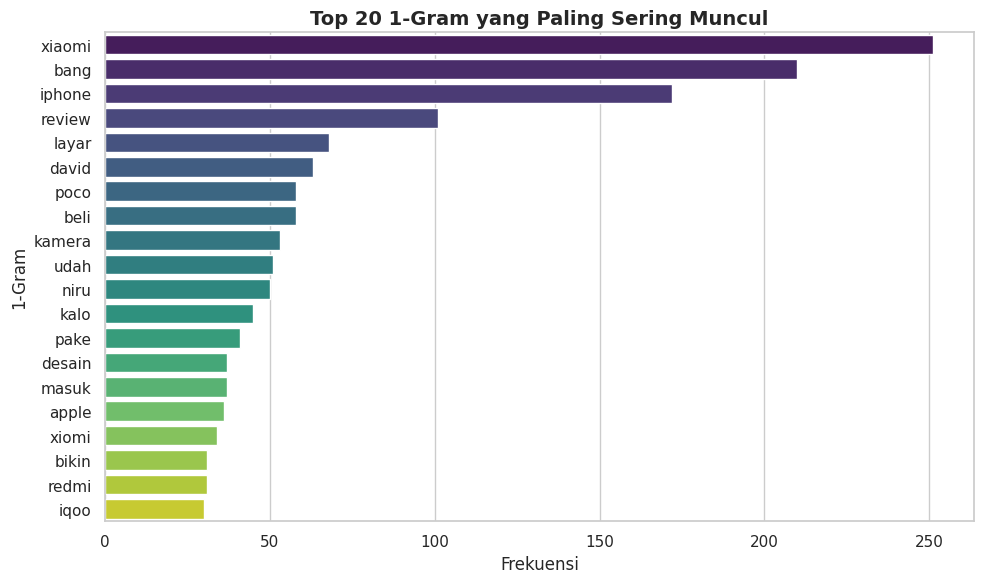

/tmp/ipython-input-688897870.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ngram_list, x=freq_list, palette="viridis")


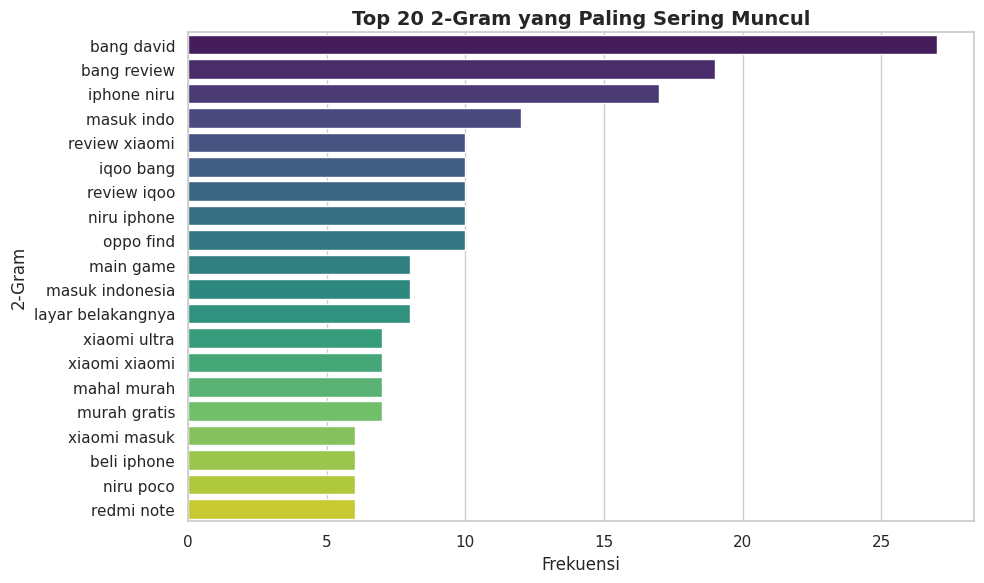

/tmp/ipython-input-688897870.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ngram_list, x=freq_list, palette="viridis")


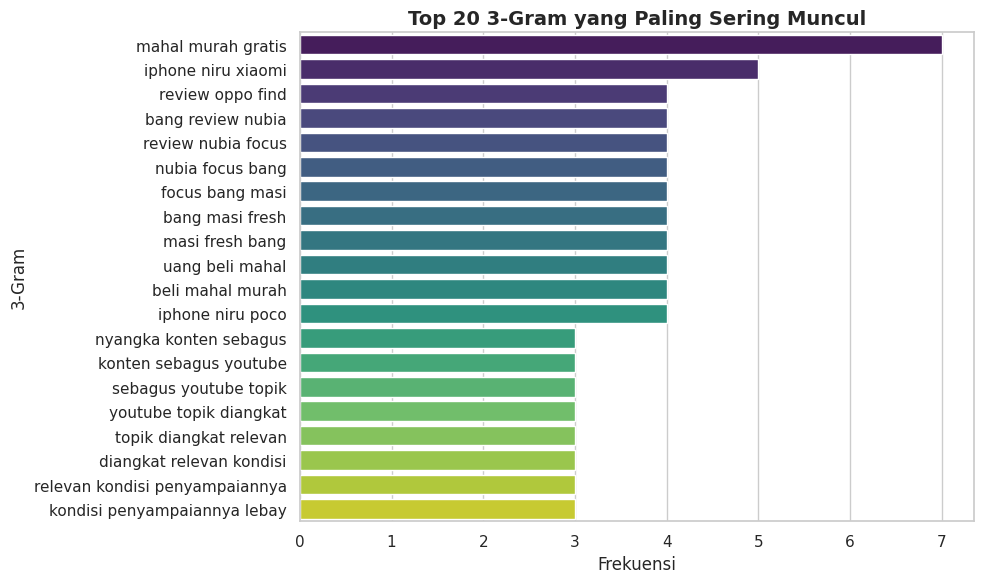

/tmp/ipython-input-688897870.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ngram_list, x=freq_list, palette="viridis")


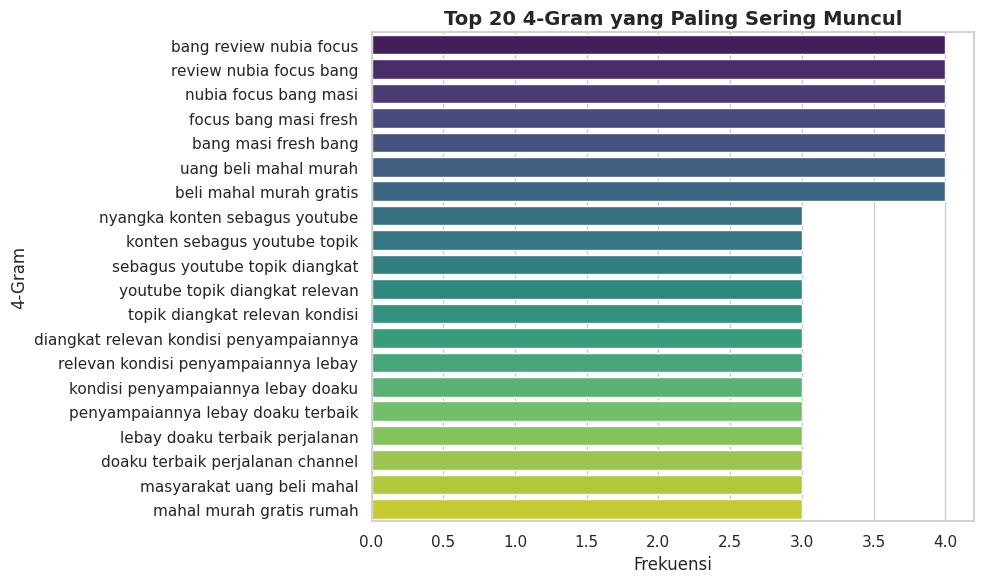

In [ ]:
for n, freq_counter in hasil_ngram.items():
    tampilkan_grafik_ngram(freq_counter, n, top_k=20)

In [ ]:
!pip install wordcloud -q
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
def tampilkan_wordcloud(freq_counter, n):
    """
    Membuat dan menampilkan Word Cloud untuk N-gram
    berdasarkan frekuensi.
    """
    if not freq_counter:
        print(f"Tidak ada data untuk {n}-gram.")
        return

    freq_dict = {" ".join(k): v for k, v in freq_counter.items()}

    wordcloud = WordCloud(
        width=1000,
        height=600,
        background_color="white",
        colormap="Oranges",   # mirip contoh kamu
        max_words=100,
        contour_width=1,
        contour_color='gray'
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud {n}-Gram", fontsize=16, weight='bold')
    plt.show()

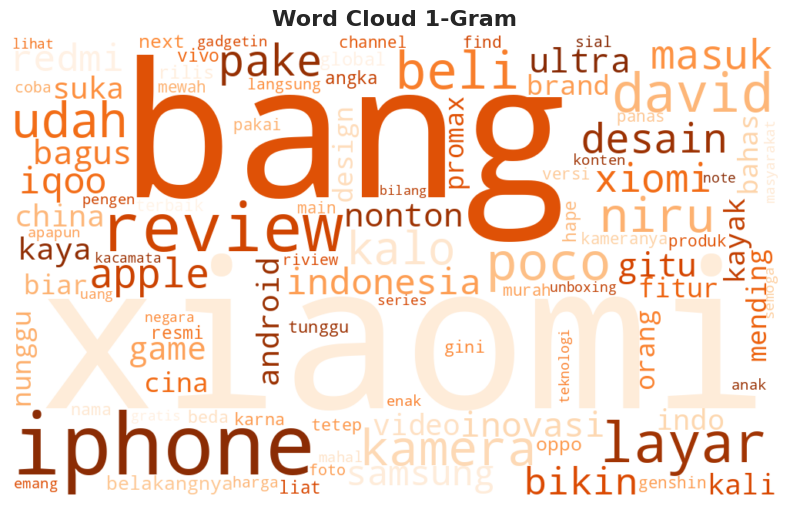

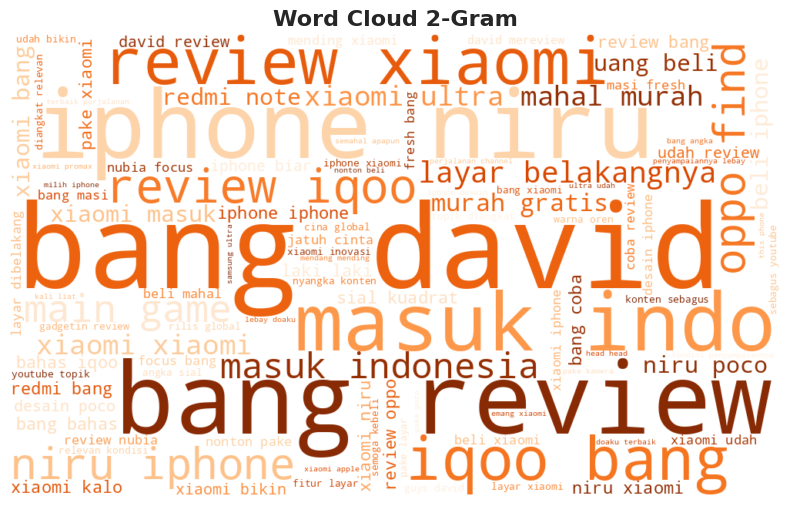

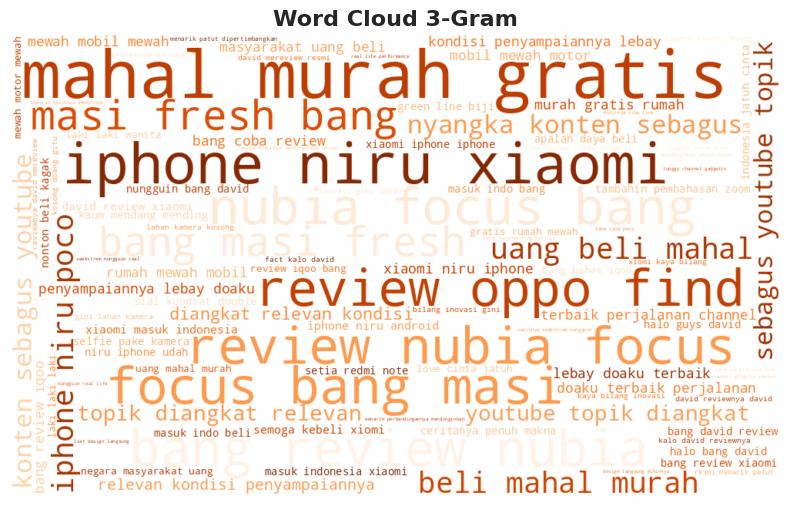

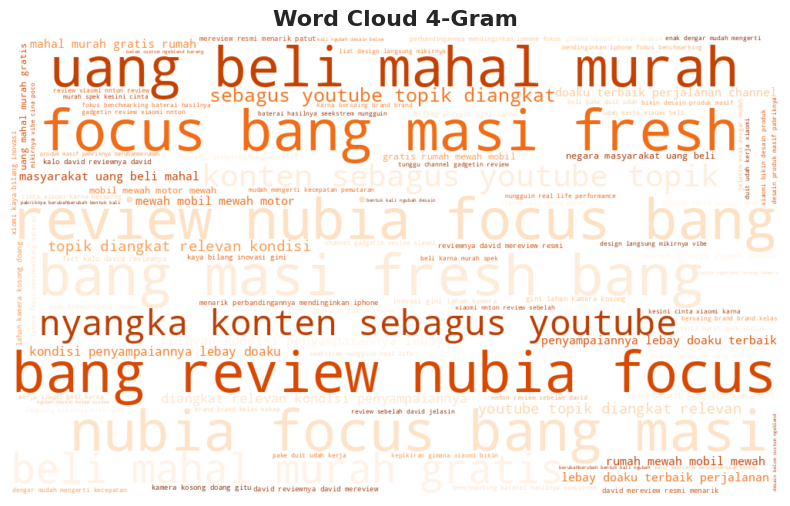

In [ ]:
for n, freq_counter in hasil_ngram.items():
    tampilkan_wordcloud(freq_counter, n)

In [ ]:
from google.colab import files
files.download(output_bigram)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>